<img src="https://www.bwhpc-c5.de/img/layout/kit_logo_V2.png" width="200" /> <img src="images/HochschuleEsslingen_Logo_RGB_DE.png" width="200" /> <img src="images/Konstanz_Logo.svg" width="200" /> <img src="images/KIT_Logo.png" width="200" />

# Dask

Dask baut auf bewährten Modulen auf und erweitert diese um Möglichkeiten zur massiven Parallelisierung. So können mehrere NumPy Arrays oder Pandas Dataframes in entsprechenden Dask-Objekten zusammengefasst und für parallele Operationen bereitgestellt werden. Die Dask Objekte stellen große Teile der bakannten API (identisch zu NumPy Arrays oder Pandas Dataframes) bereit.

Dabei kann Dask auch Daten in Objekten ablegen deren größe den verfügbaren Arbeitsspeicher übersteigt. Hierfür lagert Dask teile der Daten in eine verfügbares File System aus. Dask kann daher genutzt werden, um Datenmengen zu verarbeiten, die für Pandas oder NumPy eigentlich zu groß sind. Sind jedoch nur wenige Daten zu verarbeiten/analysieren so kann der für Dask notwendige Overhead zu einer Verlangsamung im Vergleich zu reinen NumPy/Pandas Objekten führen.

![image](images/Dask_Scale.svg)

## Dask Dashboard

Eine Übersicht über die von Dask gestarteten Parallelen Vorgänge und die Auslastung der über Dask reservierten Ressourcen kann über das Dask Dashboard eingesehen werden. Das Client Objekt aus dem dask.distributed Modul ermöglicht das Starten eines Dask Dashboards. Wird das initialisierte Client Objekt ausgegeben, so enthält die Ausgabe eine URL unter der das gestartete Dashboard abgerufen werden kann.

Wenn Jupter in Version 3.0 installiert ist oder zusätzlich Node.js (Version >= 12.0.0) und npm installiert sind, kann alternativ zur manuellen Nutzung auch das dask-labextensions Plugin in Jupyter installiert werden. Dies sorgt für eine Integration des Dask Dashboards in die Jupyter Oberfläche. Am linken Rand ist dann eine neue Schaltfläche "Dask" vorhanden. Über dies kann das Dask Dashboard erreicht werden, ohne dass hierfür eine separate URL aufgerufen werden muss.

In [2]:
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/pfs/data5/software_uc2/bwhpc/common/jupyter/base/2021-09-30/lib64/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42965 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.1.109:42965/status,
Dashboard: http://10.0.1.109:42965/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://10.0.1.109/1232881/9,Workers: 1
Dashboard: http://10.0.1.109:42965/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://10.0.1.109/1232881/12,Total threads: 4
Dashboard: http://10.0.1.109:39371/status,Memory: 1.86 GiB
Nanny: None,


In [3]:
client.close()

Aktuell funktioniert das dask-labextensions Plugin am bwUniCluster noch nicht zusmmen mit dask-mpi. Alternativ kann wie oben beschrieben direkt die URL des Dashboards genutzt werden. Hierfür muss über ssh der Port aus der URL aus dem Cluster nach außen weitergeleitet werden. Dies kann mit folgendem Befehl lokal am genutzten Rechner in einer Konsole durchgeführt werden. Der Port und die IP des Jupyter-Compute-Node können dabei der Dashboard-URL entnommen werden.

```bash
ssh -N -L <Port>:<Jupyter-Compute-Node>:<Port> <Hochschulkürzel>_<User-ID>@bwunicluster.scc.kit.edu
```

Nach Ausführen des ssh-Port-Forwardings kann am lokalen Rechner das Dask-Dashboard unter

```bash
http://localhost:<Port>/status
```

aufgerufen werden.

## Dask Array

Dask Array koordiniert mehrere NumPy Arrays und verteilt diese auf die zur Verfügung stehenden Ressourcen. So können Operationen verteilt auf mehrere Threads, Prozesse oder gar Nodes ausgeführt werden. Welche Operationen dabei möglich sind (welche Teile der NumPy Array API auch von Dask Array angeboten werden) kann der Dokumentation entnommen werden: https://docs.dask.org/en/latest/array-api.html.

Weitere Beispiele zu Dask Array: https://mybinder.org/v2/gh/dask/dask-examples/main?urlpath=lab/tree/array.ipynb

## Dask Dataframe

Was Dask Array für NumPy Arrays ist (s.o.), dass ist Dask Dataframe für Pandas Dataframe. Die auf einem Dask Dataframe möglichen Operationen können der Dokumentation entnommen werden: https://docs.dask.org/en/latest/dataframe-api.html.

Eine generelle Übersicht über sinnvolle und weniger sinnvolle Arten einen Dask Dataframe zu nutzen ist unter https://docs.dask.org/en/latest/dataframe.html zu finden.

## Dask und SLURM

Um Dask in Kombination mit SLURM (dem Job-Scheduler des bwUniClusters) nutzen zu können, wird entweder die Klasse SLURMCluster aus dem Modul dask_jobqueue oder das Programm dask-mpi benötigt.

Für die nachfolgenden Übungen wird dask-mpi benötigt. dask_jobqueue ist daher nur grundlegend beschrieben. Eine Umgebung mit allen für die Übungen benötigten Modulen wird nur in der Beschreibung von dask-mpi erstellt.

### dask_jobqueue

WICHTIG: dask_jobqueue setzt eine eins zu eins Beziehung zwischen Job und Node vorraus. D.h. pro Job wird genau ein Node reserviert und genutzt. Werden mehrere Nodes benötigt, so sieht dask_jobqueue vor, dass entsprechend viele Jobs abgesetzt werden. Dies führt auf dem bwUniCluster zu zwei grundlegenden Problemen. Zum einen werden mehrere Jobs unabhängig voneinander gescheduled. Jeder Job hat daher einen eigenen Startzeitpunkt. Es stehen also nur mit viel Glück alle benötigten Ressourcen zeitgleich zur Verfügung. Zum anderen sehen alle multiple-Queues vor, dass pro Job mindestens zwei Nodes reserviert werden. Diese Queues sind explizit für Anwendungsfälle gedacht in denen mehrere Nodes zur gleichen Zeit benötigt werden. Werden diese Queues zusammen mit dask_jobqueue genutzt, so setzt dask_jobqueue für jeden benötigten Node einen eigenen Job ab, der jeweils zwei Nodes reserviert, von denen dask_jobqueue aber dann nur einen nutzt.

Fazit:
- um mehrere Nodes zeitgleich zur Verfügung zu haben, sieht bwUniCluster einen Job in einer multiple-Queue mit mehreren Nodes pro Job vor
- dask_jobqueue setzt vorraus, dass pro Job nur ein Node genutzt wird
- anstelle von dask_jobqueue sollte dask-mpi genutzt werden


Damit dask_jobqueue zur Verfügung steht muss im jeweiligen Environment sowohl dask als auch dask_jobqueue installiert sein:

```bash
python3 -m pip install dask_jobqueue dask
```

Ist der IPython-Kernel aus einem entsprechend erweiterten Environment im Jupyter registriert, so kann dieser beim Start eines neuen Notebooks ausgewählt werden. Anschließend kann die SLURMCluster Klasse im Notebook importiert und zum Erstellen einer SLURM-Job-Konfiguration genutzt werden.

Welche queues für eine solche Konfiguration am bwUniCluster zur Verfügung stehen und welche Eigenschaften diese Haben kann der Dokumentation unter

https://wiki.bwhpc.de/e/BwUniCluster_2.0_Batch_Queues

entnommen werden.

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    queue='multiple', # queue multiple ermöglicht eine Reservierung von mehreren Nodes pro Job (min. 2 Nodes pro Job)
    cores=40, # ein Node der queue multiple besitzt 40 cores => für 80 cores werden zwei Nodes angefordert
    memory="90GB", # maximal verfügbarer Speicher pro Node in queue multiple
    local_directory='/tmp', # Daten sollen lokal im Node und nicht über Netzwerk ins zentrale Filesystem geschrieben werden
    walltime='00:30:00', # Nodes sollen eine halbe Stunde reserviert werden
    interface='ib0' # für die Netzwerkkommunikation im Cluster wollen wir schnelles Infiniband nutzen
)

Der eigentliche Job wird dann auf Basis der Konfiguration mittels der Methode scale gestartet:

In [3]:
cluster.scale(jobs=1) # beim Start der Konfiguration können auch mehrere Jobs gleichzeitig gestartet werden (hierdurch ist das Reservieren mehrerer Nodes möglich)

In [4]:
from dask.distributed import Client
client = Client(cluster)
client # enthält die Informationen über den gestarteten Cluster

<Client: 'tcp://172.26.21.158:44599' processes=10 threads=80, memory=83.80 GiB>

### dask-mpi

Die Anwendung dask-mpi ermöglicht das Starten eines dask-Clusters über MPI. Hierdurch ist es möglich, mehrere Nodes mit nur einem Job zu reservieren. Dadurch können auch Queues genutzt werden, die mehr als einen Node pro Job voraussetzen. Zudem ist sichergestellt, dass alle benötigten Nodes zum gleichen Zeitpunkt verfügbar sind (da sie über den gleichen Job angefordert wurden).

#### Environment 

Für die nachfolgenden Beispiele wird das im Notebook "2_Grundlagen" erstellte Environment benötigt. Dieses Environment muss für dieses Notebook über den entsprechenden Kernel ausgewählt sein.

Damit das im Notebook "2_Grundlagen" erstellte Environment schnell auf die genutzten Nodes kopiert werden kann, sollte dieses in ein Archiv gepackt werden (der folgende Befehl muss im Terminal File->New->Terminal ausgeführt werden):

```bash
tar -zcvf ~/miniconda3/envs/python_workshop_env.gz -C ~/miniconda3/envs/ python_workshop_env/
```

#### sbatch und Job-Script

Zum Starten eines dask-Clusters über dask-mpi wird ein Job-Script benötigt. Dieses wird später über sbatch gestartet. Sbatch sorgt dafür, dass die benötigte Anzahl an Knoten reserviert wird (dabei wird auch festgelegt, wieviele Tasks gestartet werden sollen und wie diese über die Nodes verteilt werden sollen). Nachdem die angeforderten Knoten verfügbar sind, führt sbatch das übergebene Script auf dem ersten der reservierten Nodes aus. In diesem Script können dann benötigte Daten auf die einzelnen Nodes kopiert werden (über separate Jobs, welche per srun gestartet werden; lokale Daten können im Vergleich zu Zugriffen auf das zentrale File System schneller eingelesen werden). Abschließend führt das Script einen Aufruf von mpirun aus. Über mpirun wird dask-mpi n mal gestartet. Dabei sollte n gleich der Anzahl der benötigten Worker plus eins (für den Scheduler) sein. Die Anzahl n muss dabei zur Anzahl der über sbatch konfigurierten Tasks passen.

#### Anzahl Prozesse pro Node und Anzahl Threads pro Prozess:

Pro Node sollte die Anzahl der Threads pro Prozess multipliziert mit der Anzahl der Prozesse der Summe der Verfügbaren Cores entsprechen. Nur so ist gewährleistet, dass alle Threads einen Core verfügbar haben und nicht durch andere Threads ausgebremst werden. Wenn einzelne Tasks Wartezeiten beinhalten (z.B. warten auf File-I/O oder warten auf Ergebnisse anderer Tasks) kann es allerdings besser sein, mehr parallel laufende Tasks (Prozesse oder Threads) als Cores verfügbar sind einzuplanen.

Informationen über die Queues: https://wiki.bwhpc.de/e/BwUniCluster_2.0_Batch_Queues

Informationen über die Hardware pro Node: https://wiki.bwhpc.de/e/BwUniCluster_2.0_Hardware_and_Architecture

Bei überwiegender Nutzung von numerischen Bibliotheken ist eine hohe Anzahl von Threads pro Prozess sinnvoll, da diese Bibliotheken (Numpy, Pandas, ...) so implementiert sind, dass sie nicht vom Global Interpreter Lock (GIL) von Python ausgebremst werden. Sie sind meist in C geschrieben und bieten nur ein Interface für Zugriffe aus Python. Gleichzeitig profitieren sie von der gemeinsamen Nutzung der selben Daten innerhalb eines Prozesses (keine Interprozesskommunikation zwischen Threads im gleichen Prozess nötig).

Werden hauptsächlich in Python geschriebene Algorithmen ausgeführt, so bieten sich viele Prozess mit wenigen oder gar nur je einem Thread pro Prozess an, da das GIL hier eine parallele Ausführung mit mehreren Threads in einem Prozess verhindert.

Mischungen von numerischen Bibliotheken und in Python implementierten Algorithmen machen ein ausgewogeneres Verhältnis zwischen Prozessen und Threads notwendig.

In [5]:
import os

count_nodes = 2
count_worker_per_node = 2 # auf dem ersten Node wird noch der Scheduler gestartet => der erste Node stellt einen Worker weniger zur Verfügung
count_threads_per_worker = 20
time = "30:00" # 30 min.
mem = "90000mb"

f = open(os.path.expanduser("~/job_dask_mpi.sh"), "w") # ein neues Script erstellen, welches dann per sbatch abgeschickt werden kann
f.write(f"""#!/bin/bash -l
# -l dient dazu die Einstellungen der bashrc zu übernehmen (wird für conda benötigt)

# jeden über sbatch reservierten Node einzeln in einer for-Schleife durchgehen
NODES=$(scontrol show hostname | cat)
for NODE in $NODES
do
    # pro Node einen Job per srun starten und Daten unter /tmp lokal im Node speichern
    # das "&" am ende sorgt dafür, dass der srun parallel im Hintergrund ausgeführt wird
    # der "\" am Zeilenende maskiert das Zielenende (nächste Zeile gehört noch zur aktuellen Zeile)
    # mkdir erstellt ein Verzeichnis
    # cp kopiert eine Datei
    # tar entpackt die Datei
    srun -N 1 -n 1 -w $NODE /bin/bash -c "\
        mkdir /tmp/envs && \
        cp ~/miniconda3/envs/python_workshop_env.gz /tmp/envs && \
        tar -zxf /tmp/envs/python_workshop_env.gz --directory /tmp/envs\
        " &
done

# warten auf alle parallel gestarteten Befehle
wait

# Aktivieren des lokalen Environments (muss nicht auf jedem Node durchgeführt werden, da die entsprechenden Umgebungsvariablen per mpirun übernommen werden)
conda activate /tmp/envs/python_workshop_env

# startet die Worker und einen Scheduler auf den Nodes
# --map-by core:PE=n: jedem Prozess sollen n cores fest zugewiesen werden
# -np x: x = Anzahl Worker + 1 für Scheduler (x muss gleich --ntasks bei Ausführung von sbatch sein)
# --scheduler-file: sobald alle Worker gestartet sind, schreibt der Scheduler in diese Datei die Verbindungsinformationen des dask-Clusters)
# --interface='ib0': für Kommunikation zwischen den Nodes nutzen wir Infiniband
# --local-directory='/tmp': wenn dask aufgrund fehlendem Arbeitsspeicher Daten auslagern muss, soll hierfür das lokale Dateisystem des Nodes genutzt werden
# --worker-class=distributed.Worker: keinen überwachenden Nanny-Prozess pro Worker Prozess
# --nthreads: Threads per Worker
# --name: Prefix für die Benennung der Worker in diesem Job
# --dashboard-address: der Port unter dem das Dashboard erreichbar ist (8787 ist eigentlich der Default Value, aber im aktuellen Entwicklungsstand wird dieser nicht automatisch gesetzt)
mpirun --map-by core:PE={count_threads_per_worker} \
       -np {count_nodes * count_worker_per_node} \
       dask-mpi \
       --scheduler-file ~/dask-scheduler.json \
       --interface='ib0' \
       --local-directory='/tmp' \
       --worker-class=distributed.Worker \
       --nthreads={count_threads_per_worker} \
       --name base \
       --dashboard-address=8787""")
f.close()

In [26]:
# wie viele Nodes sind pro Queue aktuell frei verfügbar
# kann auch in einem Terminal (File->New->Terminal) außerhalb des Jupyter Notebooks als Befehl "sinfo_t_idle" abgesetzt werden
os.system("sinfo_t_idle")

Partition dev_single    :      6 nodes idle
Partition single        :     39 nodes idle
Partition dev_multiple  :      8 nodes idle
Partition multiple      :     69 nodes idle
Partition fat           :      0 nodes idle
Partition dev_multiple_e:      8 nodes idle
Partition multiple_e    :      1 nodes idle
Partition dev_special   :      2 nodes idle
Partition special       :      0 nodes idle
Partition gpu_4         :      0 nodes idle
Partition dev_gpu_4     :      0 nodes idle
Partition gpu_8         :      0 nodes idle


0

In [27]:
queue = "dev_multiple"

# rm: Löschen des ~/dask-scheduler.json Files: sobald das File wieder da ist, ist der angeforderte Dask-Cluster vollständig gestartet
# sbatch: reserviert die notwendigen Ressourcen (Nodes) in der angegebenen queue und startet das Script ~/job_dask_mpi.sh auf dem ersten der Nodes
os.system(f"rm -f ~/dask-scheduler.json && \
            sbatch \
            -p {queue} \
            --nodes={count_nodes} \
            --ntasks={count_nodes * count_worker_per_node} \
            --ntasks-per-node={count_worker_per_node} \
            --time={time} \
            --mem={mem} \
            ~/job_dask_mpi.sh")

Submitted batch job 20170250


0

In [28]:
# steht bereits ein Zeitpunkt fest, an dem die Ressourcen für uns verfügbar sind?
os.system("squeue --start")

             JOBID PARTITION     NAME     USER ST          START_TIME  NODES SCHEDNODES           NODELIST(REASON)
          20170250 dev_multi job_dask es_pkoes PD                 N/A      2 (null)               (Priority)


0

In [29]:
# welche Ressourcen sind für unseren User angefordert?
# Zeigt eine Zeile pro Job mit dem Ressourcen angefordert wurden.
# ST: Status
#     PD: Pending, Ressourcen wurden angefordert, stehen aber noch nicht zur Verfügung
#     R:  Running, Ressourcen sind verfügbar
#     CG: Completing, Job ist beendet/abgebrochen, allerdings laufen noch einzelne Prozesse (die noch beendet oder abgebrochen werden)
#     weitere Status-Codes: https://curc.readthedocs.io/en/latest/running-jobs/squeue-status-codes.html
# TIME: wie lange sind die Ressourcen schon durch uns genutzt
# NODES: Anzahl der Reservierten Nodes
# NODELIST: welche Nodes sind Reserviert
#     Der Namen der Nodes ist mit einem Prefix (ist für jeden Node gleich) gefolgt von der Nummerierung der einzelnen Nodes in Eckigen Klammern angegeben.
#     Ein Bindestrich zwischen zwei Nummern in den Eckigen Klammern bedeutet, dass alle Nummern zwischen den beiden angegebenen für uns Reserviert sind.
#     Ein Komma zwischen zwei Nummern bedeutet, dass die beiden Nummern für uns Reserviert sind.
#     Beispiele:
#         uc2n[001-003] zeigt an, dass uc2n001, uc2n002 und uc2n003 reserviert wurden
#         uc2n[001,003] zeigt an, dass uc2n001 und uc2n003 reserviert wurden
os.system("squeue")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          20170250 dev_multi job_dask es_pkoes PD       0:00      2 (Priority)
          20170002    single jupyterh es_pkoes  R    1:22:35      1 uc2n365


0

In [30]:
import os, time

# warten, bis die Datei ~/dask-scheduler.json vorhanden ist (diese wird vom Dask-Scheduler geschrieben, sobald alle Worker gestartet und bereit sind)
while not os.path.isfile(os.path.expanduser("~/dask-scheduler.json")):
    time.sleep(1)

In [31]:
# Über ein Client-Objekt können wir das aktuelle Jupyter-Notebook mit dem erstellten Dask-Cluster verbinden.
# Dafür nutzen wir die ~/dask-scheduler.json Datei. In dieser sind IP und Port des Schedulers gespeichert.
# (anstatt aus einem Jupter-Notebook heraus, kann dies z.B. auch aus einem Python-Script heraus geschehen)
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('~/dask-scheduler.json'))

In [32]:
# wir lassen den Client anzeigen (dieser enthält auch Informationen zum Scheduler und den einzelnen Workern)
client

<Client: 'tcp://172.26.20.1:35307' processes=3 threads=60, memory=65.92 GiB>

### Dask Cluster nachträglich vergrößern

Weitere Worker können mit einem separaten Job erstellt und dem Scheduler aus einem vorhergehenden Job hinzugefügt werden. Hierzu wird auch die scheduler-json-Datei genutzt.

In [5]:
count_nodes = 2
count_worker_per_node = 2
count_threads_per_worker = 20
time = "30:00" # 30 min.
mem = "90000mb"

queue = "dev_multiple"

# ein Script um einen existierenden Cluster zu erweitern
f = open(os.path.expanduser("~/job_dask_mpi_2.sh"), "w")
f.write(f"""#!/bin/bash -l
NODES=$(scontrol show hostname | cat)
for NODE in $NODES
do
    srun -N 1 -n 1 -w $NODE /bin/bash -c "\
        mkdir /tmp/envs && \
        cp ~/miniconda3/envs/python_workshop_env.gz /tmp/envs && \
        tar -zxf /tmp/envs/python_workshop_env.gz --directory /tmp/envs\
        " &
done

wait

conda activate /tmp/envs/python_workshop_env

# da ein existierender Dask-Cluster erweitert werden soll:
# --no-scheduler: erstelle keinen eigenen Scheduler, sondern registriere die Worker an dem im scheduler-file angegebenen Scheduler
mpirun --map-by core:PE={count_threads_per_worker} \
       -np {count_nodes * count_worker_per_node} \
       dask-mpi \
       --scheduler-file ~/dask-scheduler.json \
       --interface='ib0' \
       --local-directory='/tmp' \
       --worker-class=distributed.Worker \
       --nthreads={count_threads_per_worker} \
       --no-scheduler \
       --name expansion""")
f.close()

# einen Node über sbatch reservieren und das Script auf diesem ausführen
os.system(f"sbatch \
            -p {queue} \
            --nodes={count_nodes} \
            --ntasks={count_nodes * count_worker_per_node} \
            --ntasks-per-node={count_worker_per_node} \
            --time={time} \
            --mem={mem} \
            ~/job_dask_mpi_2.sh")

Submitted batch job 20170157


0

In [6]:
os.system("squeue")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          20170157 dev_multi job_dask es_pkoes PD       0:00      2 (Priority)
          20170133 dev_multi job_dask es_pkoes  R       6:34      2 uc2n[001-002]
          20170002    single jupyterh es_pkoes  R      49:10      1 uc2n365


0

In [7]:
# warten bis 15 Worker verfügbar sind (3 aus dem ersten Job und 4 aus dem zweiten)
client.wait_for_workers(7)

In [9]:
# wir lassen den Client anzeigen (dieser enthält auch Informationen zum Scheduler und den einzelnen Workern)
client

<Client: 'tcp://172.26.20.1:35517' processes=3 threads=60, memory=65.92 GiB>

In [ ]:
# anstatt einen Client über die json Datei mit einem Dask-Cluster zu verbinden, kann auch eine IP-Adresse genutzt werden
from distributed import Client
client = Client('172.26.20.1:8786')

In [ ]:
client

## Beispiel Dask Array

In [11]:
import dask.array as da

# Erstellt ein Array mit 100000 Zeilen und 100000 Spalten.
# Jedes Element enthält einen zufälligen Wert aus dem Intervall [0.0, 1.0).
#
# Das Array wird in einzelne Chunks unterteilt. Jeder Chunk wird durch
# einen separaten Task erstellt. So kann jeder Chunk von Dask auf einen
# anderen Worker verteilt werden.
# Die Tasks werden erst ausgeführt, wenn mit dem Array gearbeitet wird.
# x enthält daher kein fertiges Array, sondern lediglich die Tasks,
# die zum Erstellen des Arrays notwendig sind.
# Anstelle einer Vorgabe der maximalen Chunk-Größe in MiB kann auch die
# Anzahl der Elemente pro Chunk definiert werden (siehe
# https://docs.dask.org/en/latest/array-chunks.html).
x = da.random.random((100000,100000), chunks="100 MiB")
x

dask.array<random_sample, shape=(100000, 100000), dtype=float64, chunksize=(3125, 3125), chunktype=numpy.ndarray>

In [12]:
# Eine Rechenoperation auf einem Dask Array erstellt zunächst nur Tasks.
# Diese werden erst ausgeführt, wenn ein Ergebnis angefordert wird.
y = (x + x.T) - x.mean(axis=0)
y

dask.array<sub, shape=(100000, 100000), dtype=float64, chunksize=(3125, 3125), chunktype=numpy.ndarray>

In [13]:
# Die Methode compute() fordert ein konkretes Ergebnis an. Durch den
# Aufruf dieser Methode werden die geplanten Tasks ausgeführt.
y.sum().compute()

4999978224.698928

## Beispiel Dask Dataframe und Scikit-Learn

Basiert auf https://github.com/rikturr/high-performance-jupyter (MIT-License).

In [14]:
%%time
# %%time misst die Zeit, die eine Code-Zelle im Jupyter-Notebook zur Ausführung braucht
# %%time muss in der ersten Zeile der Zelle stehen

import dask.dataframe as dd

# erstellt Tasks um ~8 GB Daten aus einem s3 Bucket zu laden und als Dataframe einzulesen
taxi = dd.read_csv(
    's3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv',
    assume_missing=True, # beim Einlesen werden alle Ints zu Floats. Dies erlaubt fehlende Werte
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], # interpretiert diese Spalten als Datum
    storage_options={'anon': True}, # für S3: keine Authentifizierung für diesen Bucket nötig
)
taxi

CPU times: user 399 ms, sys: 193 ms, total: 592 ms
Wall time: 2.93 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=127,,,,,,,,,,,,,,,,,,
,float64,datetime64[ns],datetime64[ns],float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
%%time

# beide folgenden Zeilen führen die in "taxi" enthaltenen Tasks aus,
# um deren Ergebnis für weitere Operationen zu nutzen
# => Einlesen in den Dataframe wird zwei mal ausgeführt!
print(f"Anzahl Zeilen: {len(taxi)}") #Zeilen aller Datensätze zusammen
print(f"Größe in GB: {taxi.memory_usage(deep=True).sum().compute() / 1e9}")

Anzahl Zeilen: 84399019
Größe in GB: 16.367014316
CPU times: user 166 ms, sys: 51 ms, total: 217 ms
Wall time: 2min 24s


In [16]:
from dask.distributed import wait

# persist() führt alle geplanten Tasks im Hintergrund (asynchron) aus und gibt das Ergebnis zurück
# wir ersetzen demnach hier die Tasks durch den fertigen Dataframe
taxi = taxi.persist()
# wait() wartet auf die im Hintergrund gestarteten Tasks
_ = wait(taxi)

In [17]:
%%time

# len() und memory_usage() sind deutlich schneller, wenn auf dem persistierten
# Ergebnis der Tasks gearbeitet wird
print(f"Anzahl Zeilen: {len(taxi)}") #Zeilen aller Datensätze zusammen
print(f"Größe in GB: {taxi.memory_usage(deep=True).sum().compute() / 1e9}")

Anzahl Zeilen: 84399019
Größe in GB: 16.367014316
CPU times: user 53.8 ms, sys: 2.14 ms, total: 56 ms
Wall time: 2.29 s


In [18]:
numeric_feat = [
    'pickup_weekday', 
    'pickup_hour', 
    'pickup_week_hour', 
    'pickup_minute', 
    'passenger_count',
]
categorical_feat = [
    'PULocationID', 
    'DOLocationID',
]
features = numeric_feat + categorical_feat
y_col = 'high_tip'

In [19]:
def prep_df(df: dd.DataFrame) -> dd.DataFrame:
    '''
    Generate features from a raw taxi dataframe.
    '''
    df = df[df.fare_amount > 0]  # nur Zeilen übernehmen, die nicht 0 sind (kein Teilen durch 0)
    df['tip_fraction'] = df.tip_amount / df.fare_amount
    df[y_col] = (df['tip_fraction'] > 0.2) # wenn tip_amount / fare_amount > 0.2, dann high_tip = true
    
    df['pickup_weekday'] = df.tpep_pickup_datetime.dt.weekday
    df['pickup_weekofyear'] = df.tpep_pickup_datetime.dt.isocalendar().week
    df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
    df['pickup_week_hour'] = (df.pickup_weekday * 24) + df.pickup_hour
    df['pickup_minute'] = df.tpep_pickup_datetime.dt.minute
    
    # alle Eingaben für das Training in float umwandeln und nicht vorhandene Werte auf -1 setzen
    df = df[features + [y_col]].astype(float).fillna(-1)
    
    return df
    
taxi = prep_df(taxi)
taxi

,pickup_weekday,pickup_hour,pickup_week_hour,pickup_minute,passenger_count,PULocationID,DOLocationID,high_tip
npartitions=127,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [20]:
%%time

# Tasks zum Aufbereiten des Dataframes (prep_df) ausführen
taxi = taxi.persist()
_ = wait(taxi)

CPU times: user 48.9 ms, sys: 8.48 ms, total: 57.4 ms
Wall time: 11.1 s


In [21]:
taxi.head()

,pickup_weekday,pickup_hour,pickup_week_hour,pickup_minute,passenger_count,PULocationID,DOLocationID,high_tip
0,1.0,0.0,24.0,46.0,1.0,151.0,239.0,1.0
1,1.0,0.0,24.0,59.0,1.0,239.0,246.0,0.0
2,4.0,13.0,109.0,48.0,3.0,236.0,236.0,0.0
3,2.0,15.0,63.0,52.0,5.0,193.0,193.0,0.0
4,2.0,15.0,63.0,56.0,5.0,193.0,193.0,0.0


In [22]:
%%time

import numpy as np

# describe() generiert für jede Spalte eine Statistik-Übersicht (Min., Max., Quantile, ...)
np.round(taxi.describe().compute(), 3).T

CPU times: user 163 ms, sys: 9.09 ms, total: 172 ms
Wall time: 4.09 s


,count,mean,std,min,25%,50%,75%,max
pickup_weekday,84194625.0,2.977,1.933,0.0,2.0,4.0,6.0,6.0
pickup_hour,84194625.0,13.890,6.021,0.0,12.0,16.0,22.0,23.0
pickup_week_hour,84194625.0,85.350,46.356,0.0,62.0,109.0,146.0,167.0
pickup_minute,84194625.0,29.564,17.340,0.0,15.0,30.0,45.0,59.0
passenger_count,84194625.0,1.555,1.214,-1.0,1.0,1.0,2.0,9.0
PULocationID,84194625.0,163.161,66.011,1.0,132.0,162.0,234.0,265.0
DOLocationID,84194625.0,161.342,70.245,1.0,116.0,163.0,236.0,265.0
high_tip,84194625.0,0.541,0.498,0.0,0.0,1.0,1.0,1.0


In [23]:
seed = 42

taxi_sample = taxi.sample(frac=0.02, replace=False, random_state=seed)
taxi_sample = taxi_sample.persist()
_ = wait(taxi_sample)

len(taxi_sample)

1683892

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from dask_ml.compose import ColumnTransformer
from dask_ml.preprocessing import StandardScaler, DummyEncoder, Categorizer
from dask_ml.model_selection import GridSearchCV

seed = 42

lr = LogisticRegression(
    solver='saga',
    penalty='elasticnet', 
    l1_ratio=0.5,
    max_iter=100, 
    random_state=seed,
)
pipeline = Pipeline(steps=[
    ('categorize', Categorizer(columns=categorical_feat)),
    ('onehot', DummyEncoder(columns=categorical_feat)),
    ('scale', ColumnTransformer(transformers=[('num', StandardScaler(), numeric_feat)])),
    ('clf', lr),
])

params = {
    'clf__l1_ratio': [0.2, 0.3, 0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(
    pipeline, 
    params,
    cv=3, 
    scoring='accuracy',
)

In [25]:
%%time

# Bevor fit() aufgerufen wird, kann joblib mitgeteilt
# werden, dass ein Dask Cluster verfügbar ist.
# joblib wird von scikit-learn genutzt, um zu
# parallelisieren. Dies kann hilfreich sein, sofern
# nicht bereits Ojekte von dask_ml genutzt werden.
#import joblib # wird benötigt, um scikit-learn mit dem Dask Cluster zu verbinden
#with joblib.parallel_backend('dask'):
#    _ = grid_search.fit(taxi_sample[features], taxi_sample[y_col])
_ = grid_search.fit(taxi_sample[features], taxi_sample[y_col])

grid_search.best_score_

CancelledError: 

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Funktionen als Tasks

Mit dem Dekorator "delayed" können Funktionen beim Aufruf in Tasks umgewandelt werden. Diese Tasks werden dann von Dask ausgeführt, sobald ein Ergebnis angefordert wird. Das Einplanen und Ausführen eines Tasks erzeugt Overhead. Ein Task sollte daher immer möglichst viel Rechenaufwand enthalten. Es kann kontraproduktiv sein, Tasks möglichst klein zu halten. Das folgende Beispiel dient nur zum Verständnis von Tasks. Es enthält zu kleine Tasks. Wird der range() in der for-Schleife vergrößert, ergeben sich daraus schnell Probleme (Dask generiert Warnungen).

delayed-Funktionen unterliegen Einschränkungen. Z.B. können sie nicht in einer Bedingung (if- oder Schleifen-Bedingung) genutzt werden.

Weitere Informationen zu delayed: https://docs.dask.org/en/stable/delayed-api.html

In [34]:
import dask.delayed as delayed

@delayed
def increment(x):
    return x + 1

@delayed
def power2(x):
    return x ^ 2

@delayed
def add(x, y):
    return x + y

# Erstellen von 10000 Tasks (bestehend aus je zwei Tasks) in einer list
output = []
for x in range(1, 10000):
    a = increment(x)
    b = power2(x)
    c = add(a, b)
    output.append(c)

# Ein neuer Task, basierend auf der list
total = delayed(sum)(output)
total

Delayed('sum-ac472749-64d8-4cd1-acdb-91582d32a133')

In [35]:
# Tasks Ausführen
res = total.compute()
res

99999997

## Visualisierung von Dask-Tasks

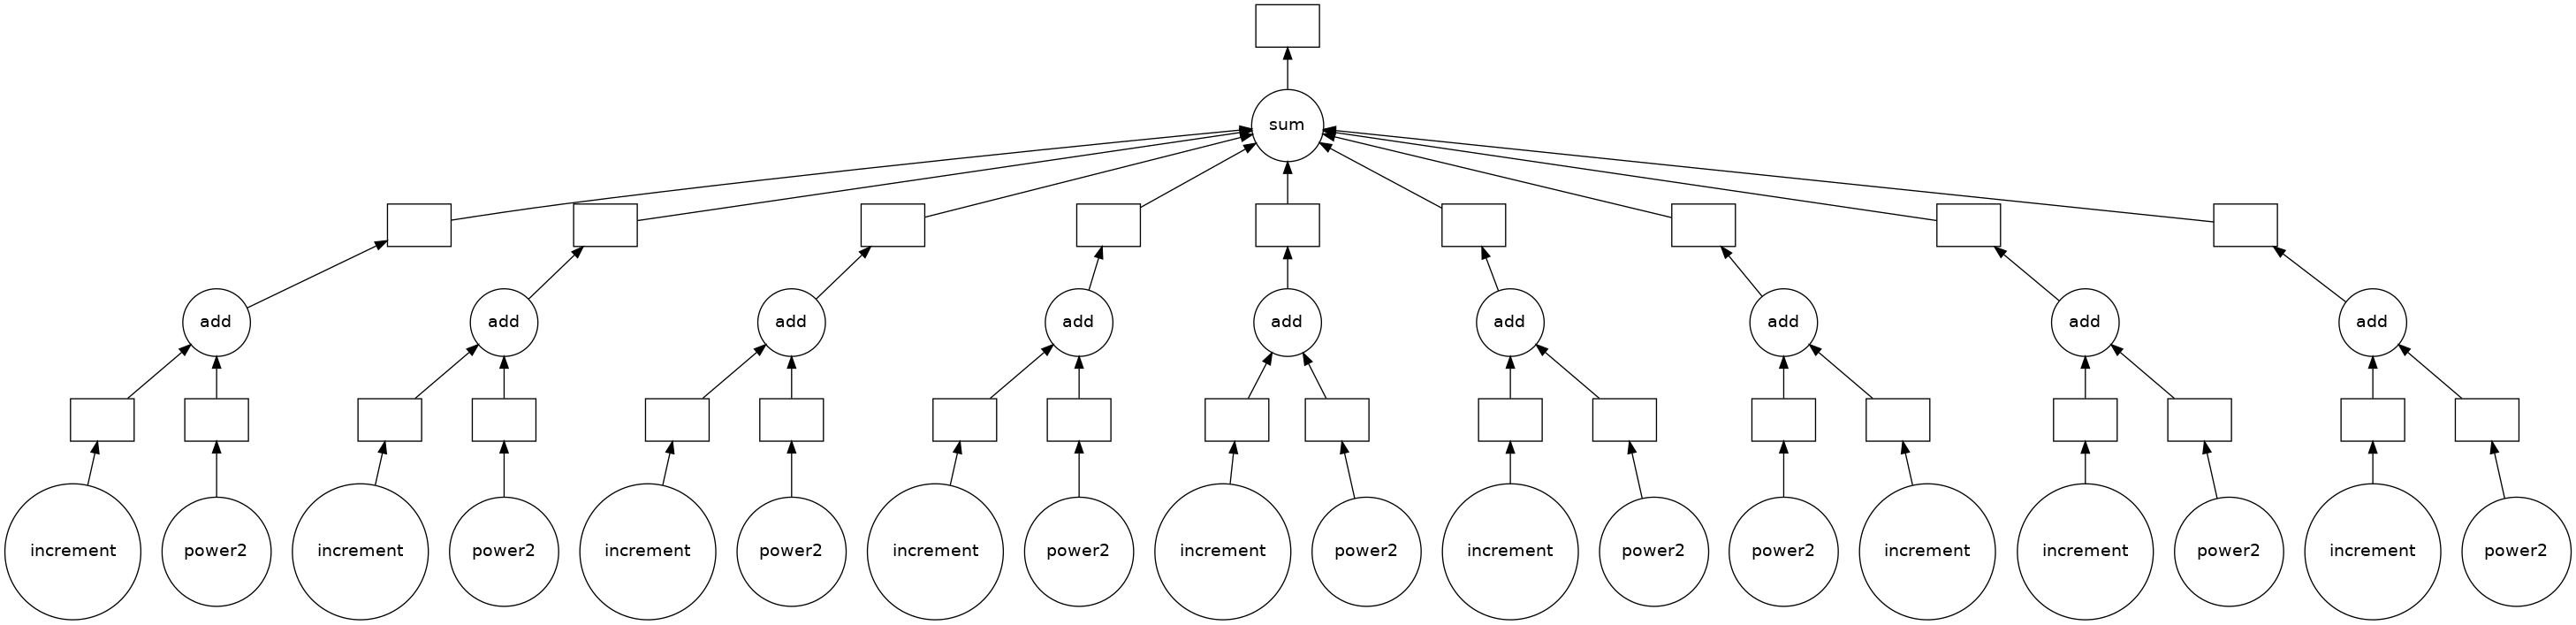

In [36]:
output2 = []
# damit der generierte Graph übersichtlich bleibt: nur 10 Iterationen
for x in range(1, 10):
    a = increment(x)
    b = power2(x)
    c = add(a, b)
    output2.append(c)

total2 = delayed(sum)(output2)
total2.visualize()

In [37]:
res = total2.compute()
res

101

## Progress Bar

In [38]:
client.close() # ProgressBar funktioniert nur, wenn kein Dask Cluster aktiv verbunden ist

from dask.diagnostics import ProgressBar

with ProgressBar():
    res = total.compute()
res

[########################################] | 100% Completed |  6.7s


99999997

## Ressourcen freigeben (Jobs beenden)

In [ ]:
# werden Ressourcen nicht länger gebraucht, so muss der zugehörige Job beendet werden,
# um die Ressourcen (Nodes) wieder freizugeben.
job_id = ????????
os.system(f"scancel {job_id}")